<a href="https://colab.research.google.com/github/aaroncnb/PyAtmos_net/blob/master/fdl_data_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic imports and setup

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/FDL_PyAtmos")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F

use_gpu = True

input_size  = 10
hidden_1_size = 8
hidden_2_size = 4
output_size = 2

input_columns  = ["input_CH4", "input_CO2", 
                  "input_H2" , "input_H2O",
                  "input_O2" , "flux_CH4" ,
                  "flux_CO2" , "flux_H2"  ,
                  "flux_H2O" , "flux_O2"    ]

output_columns = ["temperature_kelvin", "pressure_bar"]

df_exotable = pd.read_csv('pyatmos_summary.csv')
df_exotable.head(5)
df_exotable.describe()


,concentration_CH4,concentration_CO2,concentration_H2,concentration_H2O,concentration_O2,flux_CH4,flux_CO2,flux_H2,flux_H2O,flux_O2,input_CH4,input_CO2,input_H2,input_H2O,input_O2,pressure_bar,temperature_kelvin
count,124314.000000,124314.000000,1.243140e+05,124314.000000,124314.000000,1.243140e+05,1.243140e+05,1.243140e+05,1.243140e+05,1.243140e+05,124314.000000,124314.000000,1.243140e+05,124314.000000,124314.000000,124314.000000,124314.000000
mean,0.016010,0.027211,1.113814e-02,0.012300,0.212116,5.658597e+14,-5.630317e+14,1.570561e+14,-5.884775e+12,1.283378e+15,0.016010,0.027211,1.113814e-02,0.102584,0.212116,1.086672,316.158537
std,0.017930,0.028440,2.245329e-02,0.000005,0.071413,4.807145e+14,4.803728e+14,3.108504e+14,9.854423e+12,1.029946e+15,0.017930,0.028440,2.245329e-02,0.116530,0.071413,0.037779,9.295048
min,0.000002,0.000400,6.400000e-08,0.012300,0.020000,4.450000e+09,-2.000000e+15,-1.500000e+13,-3.840000e+13,5.470000e+11,0.000002,0.000400,6.400000e-08,0.010000,0.020000,1.013100,251.240000
25%,0.000002,0.000400,8.000000e-08,0.012300,0.180000,1.660000e+11,-9.620000e+14,-9.030000e+12,-1.150000e+13,1.240000e+14,0.000002,0.000400,8.000000e-08,0.012300,0.180000,1.060400,311.460000
50%,0.010000,0.020000,8.200000e-08,0.012300,0.210000,5.940000e+14,-5.900000e+14,-4.860000e+12,-1.960000e+12,1.290000e+15,0.010000,0.020000,8.200000e-08,0.050000,0.210000,1.085600,318.230000
75%,0.020000,0.040000,1.000000e-02,0.012300,0.240000,9.650000e+14,-4.840000e+11,1.790000e+14,2.150000e+12,2.070000e+15,0.020000,0.040000,1.000000e-02,0.150000,0.240000,1.115200,322.970000
max,0.130000,0.400000,1.900000e-01,0.012400,0.900000,2.000000e+15,3.200000e+13,1.480000e+15,5.430000e+12,4.280000e+15,0.130000,0.400000,1.900000e-01,0.800000,0.900000,1.194100,332.050000


In [3]:
df_exotable[input_columns].iloc[1222,:].values#.astype(np.uint8)


array([ 5.00e-02,  2.00e-02,  5.00e-02,  3.00e-02,  2.40e-01,  9.09e+14,
       -9.07e+14,  9.28e+14, -2.91e+13,  2.40e+15])

# Dataloader creation, test/train split etc.

In [4]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

class DatasetEXOATMOS(Dataset):
    
    def __init__(self, file_path, input_columns, output_columns, transform=None):

        data    = pd.read_csv(file_path)
        data    = data.drop(["hash"], axis=1)
        columns = data.columns
        scaler  = MinMaxScaler(feature_range=(-1, 1), copy=True)
        
        self.scaler         = scaler.fit(data[input_columns])
        data[input_columns] = self.scaler.transform(data[input_columns])
        self.data           = pd.DataFrame(data, columns= columns)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        inputs = self.data[input_columns].iloc[index].values#.astype(np.uint8)#.reshape((1, 28, 28))
        label  = self.data[output_columns].iloc[index].values
            
        return inputs, label

train_dataset = DatasetEXOATMOS('pyatmos_summary.csv', input_columns, output_columns)

train_size = int(0.8 * len(df_exotable))
test_size  = len(df_exotable) - train_size
#val_size   = int()

train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = 1024, shuffle = False)


planet, label = train_dataset.__getitem__(0)

planets_train, labels_train = next(iter(train_loader))
planets_test,  labels_test  = next(iter(test_loader))



planets_train = planets_train.float()
planets_test  = planets_test.float()
labels_train  = labels_train.float()
labels_test   = labels_test.float()

print('planets shape on batch size = {}'.format(planets_train.size()))
print('labels shape on batch size = {}'.format(labels_train.size()))

planets shape on batch size = torch.Size([128, 10])
labels shape on batch size = torch.Size([128, 2])


# Model definition (2-layer perceptron)

In [5]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_1_size, hidden_2_size, output_size):
            
            super(Feedforward, self).__init__()

            self.input_size    = input_size
            self.hidden_1_size = hidden_1_size
            self.hidden_2_size = hidden_2_size
            self.output_size   = output_size
            self.fc1           = torch.nn.Linear(self.input_size, self.hidden_1_size)
            #self.relu          = torch.nn.ReLU()
            self.relu          = torch.nn.LeakyReLU()
            self.fc2           = torch.nn.Linear(self.hidden_1_size, self.hidden_2_size)
            self.sigmoid       = torch.nn.Sigmoid()
            self.fc3           = torch.nn.Linear(self.hidden_2_size, self.output_size)


        def forward(self, x):

            hidden1 = self.fc1(x)
            relu1   = self.relu(hidden1)
            hidden2 = self.fc2(relu1)
            relu2   = self.relu(hidden2)
            output  = self.fc3(relu2)

            # hidden1 = self.fc1(x)
            # relu1   = self.relu(hidden1)
            # hidden2 = self.fc2(relu1)
            # relu2   = self.relu(hidden2)
            # output  = self.fc3(relu2)



            return output

In [6]:
# Optimizer setup and training functio

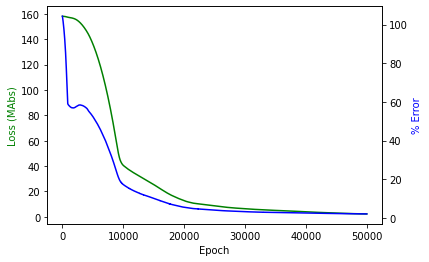

In [7]:

model     = Feedforward(input_size, hidden_1_size, hidden_2_size, output_size)
#criterion = torch.nn.MSELoss() # Mean squared error since we're using continuous variables
criterion = torch.nn.L1Loss() # Mean abs error, used mainly in regression problems.

# model.eval()
# y_pred       = model(planets_test)
# before_train = criterion(y_pred.squeeze(), labels_test)
# print('Test loss before training' , before_train.item())

if use_gpu:
    model = model.cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

def train(model, data_train, labels_train, optimizer, criterion, epochs = 200):

    lst_train_losses = []
    lst_perc_errors  = []
    
    model.train()

    if use_gpu:
        #model = model.cuda()
        data_train    = data_train.cuda()
        labels_train  = labels_train.cuda()

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(data_train)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), labels_train)

        perc_error = torch.mean(torch.abs(y_pred.squeeze() - labels_train)/labels_train)*100.0

        
    
        #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        # Backward pass
        loss.backward()
        optimizer.step()

        lst_train_losses.append(loss)
        lst_perc_errors.append(perc_error)

    # plt.plot(range(epochs), train_losses)
    # plt.plot
    #perc_error = lst_train_losses / labels_train * 100.0
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(range(epochs), lst_train_losses, 'g-')
    ax2.plot(range(epochs), lst_perc_errors, 'b-')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MAbs)', color='g')
    ax2.set_ylabel('% Error',     color='b')

    plt.show()

    return model, lst_train_losses

model, train_losses = train(model, planets_train, labels_train, optimizer, criterion, epochs = 50000) 



In [8]:
# Test function setup

In [9]:
def test(model, test_loader):

    model.eval()
    test_loss = 0
    correct   = 0

    with torch.no_grad():
        for data, target in test_loader:

            data   = data.float()
            target = target.float()
            data, target = data.cuda(), target.cuda()
            output       = model(data)
            test_loss   += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}'.format(test_loss))

In [10]:
#test(model, test_loader)

# Prepare inference code (works on a single example or list of them)

In [11]:
model_cpu = model.cpu()

In [12]:
def infer(planet, model):

    model.eval()

    label = model(planet.float())

    " For planet features {}, returned output characters of {}"
    return label

# Prepare the test data to be fed to inference function

In [13]:

#data    = pd.read_csv(file_path)
#data    = data.drop(["hash"], axis=1)
#columns = data.columns
planet = df_exotable[input_columns].iloc[test_dataset.indices,:].values
#planet = planet.reshape(1,-1)
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)        
scaler = scaler.fit(planet)
planet = scaler.transform(planet)
planet = torch.tensor(planet)
planet

tensor([[-1.0000, -0.4686, -1.0000,  ..., -0.9815,  0.8757, -0.9998],
        [-0.9167, -0.5354, -1.0000,  ..., -0.9883,  0.7665, -0.6666],
        [-1.0000, -1.0000, -0.8824,  ..., -0.8961,  0.9348, -0.9842],
        ...,
        [-0.6667, -0.7356, -0.6471,  ...,  0.0766,  0.1541, -0.2786],
        [-0.6667, -1.0000, -0.4118,  ...,  0.4069,  0.0087, -0.3367],
        [-0.8334, -1.0000, -1.0000,  ..., -0.9919,  0.7367, -0.3561]],
       dtype=torch.float64)

# Get prediction table for test data

In [14]:
test_predictions = infer(planet, model_cpu)
test_predictions

tensor([[319.6947,   1.0519],
        [322.0025,   1.0797],
        [305.5704,   1.0683],
        ...,
        [322.4119,   1.0784],
        [319.9330,   1.0676],
        [310.9544,   1.1018]], grad_fn=<AddmmBackward>)

Prepare ground-truth for test data

In [15]:
test_groundtruth = torch.tensor(df_exotable[output_columns].iloc[test_dataset.indices].values)
test_groundtruth

tensor([[318.9500,   1.1129],
        [324.2900,   1.1060],
        [292.6500,   1.0355],
        ...,
        [324.7200,   1.1400],
        [311.2300,   1.0794],
        [308.9600,   1.0306]], dtype=torch.float64)

# Calculate % errors for test data

In [16]:
test_perc_errors = ((test_groundtruth - test_predictions) / test_groundtruth ) * 100.0
test_perc_errors

tensor([[-0.2335,  5.4834],
        [ 0.7054,  2.3739],
        [-4.4150, -3.1651],
        ...,
        [ 0.7108,  5.4018],
        [-2.7963,  1.0924],
        [-0.6455, -6.9069]], dtype=torch.float64, grad_fn=<MulBackward0>)

# Plot % errors for temp and pressure

Text(0.5, 0, '% error')

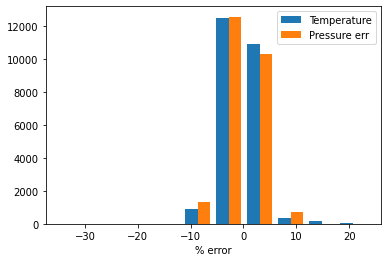

In [17]:
plt.hist(test_perc_errors.detach().numpy(), label=['Temperature', 'Pressure err'])
plt.legend()
plt.xlabel('% error')

In [18]:
test_dataset.dataset.data[output_columns]

,temperature_kelvin,pressure_bar
0,320.29,1.0629
1,320.26,1.1183
2,320.21,1.1036
3,313.87,1.0685
4,322.48,1.1177
...,...,...
124309,324.08,1.1072
124310,316.41,1.1041
124311,316.89,1.0964
124312,314.88,1.0532
